In [1]:
import numpy as np
from PIL import Image
import csv
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sn
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [3]:
valid = pd.read_json("/Users/ratulghoshr/Desktop/UCI_NLP.nosync/dl_project/dev_seen.jsonl", lines=True)
valid.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [4]:
actual = {valid['id'][i]:valid['label'][i] for i in range(500)}

In [5]:
'''
Returns True Positives, False Positives, True Negatives, False Negatives, AUROC_score
'''
def Statistics(actual, pred_labels, pred_prob, sorted_dict):
    
    #Correctly Predicted
    True_positives = defaultdict(int)
    True_negatives = defaultdict(int)


    #Benign Meme but predicted hateful
    False_positives = defaultdict(int)

    # Hateful Meme, but predicted Benign
    False_negatives = defaultdict(int)



    for ids in list(actual.keys()):

        if actual[ids] != pred_labels[ids]:

            if pred_prob[ids]>=0.5:
                False_positives[ids] = pred_prob[ids]

            else:
                 False_negatives[ids] = pred_prob[ids]   


        else:
            if pred_prob[ids]>=0.5:
                True_positives[ids] = pred_prob[ids]

            else:
                 True_negatives[ids] = pred_prob[ids]   
            
        
    return sorted_dict(True_positives), sorted_dict(True_negatives), sorted_dict(False_positives),  sorted_dict(False_negatives)
     

    

'''
Get count of True Positives, False Positives, True Negatives, False Negatives
'''
def count(True_positives, True_negatives, False_positives,  False_negatives):
    
    tp = len(True_positives)
    tn = len(True_negatives)
    fp = len(False_positives)
    fn = len(False_negatives)
    total = tp+tn+fp+fn
    
    return tp,tn,fp,fn,total




'''
Plots Confusion Matrix
'''
def plot_confusion_matrix(tn, fp, fn, tp, AUROC_score,total):
    
    
    matrix = np.array(([tn, fp],[fn,tp]))
    percent = (matrix/matrix.sum())*100
    
    accuracy = ((tp+tn)/total)*100
    Precision = (tp/(tp+fp))*100
    Recall = (tp/(tp+fn))*100
    F1_score =  2 * (Precision * Recall) / (Precision + Recall)
    
    
    df_cm = pd.DataFrame(matrix, ['Benign','Hateful'], ['Benign','Hateful'])
    text = np.asarray([['True Negatives', 'False Positives'], ['False Negatives', 'True Positives']])
    label = (np.asarray(["{0}\n\n{1}\n\n{2: .2f}%".format(text,matrix,percent) for text, matrix, percent in zip(text.flatten(), matrix.flatten(), percent.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(10,10))
    sn.set(font_scale=2)
    sn.heatmap(df_cm, annot=label, annot_kws={"size": 20}, cbar_kws={'label':"Memes"}, fmt ='', cmap ='Blues')
    
    plt.title('Confusion Matrix', fontsize=20)
    plt.text(0.1, 2.5, 'Precision: '+str(round(Precision,2)) + '        Recall: '+str(round(Recall,2))+'     F1 Score: '+str(round(F1_score,2))+
            '\n\nAccuracy: '+ str(round(accuracy,2))+'          AUROC:'+ str(round(AUROC_score,2)), fontsize=20)
    plt.show()

    
    
    
'''
Get AUROC score using sklearn.metrics.roc_auc_score
'''
def get_AUROC(actual, pred_labels):
    
    ytrue=[]
    ypred=[]
    for ids in list(actual.keys()):
        ytrue.append(actual[ids])
        ypred.append(pred_labels[ids])

    AUROC_score = roc_auc_score(ytrue, ypred)
    
    return AUROC_score




'''
Return a Dictionary by it's values sorted in descending order
'''
def sorted_dict(unsorted_dictionary):
    sorted_keys = sorted(unsorted_dictionary, key =unsorted_dictionary.__getitem__, reverse=True)

    sorted_values = sorted(unsorted_dictionary.values(),reverse=True)

    sorted_dictionary = {}
    for i in range(len(sorted_keys)):
        sorted_dictionary[sorted_keys[i]] = sorted_values[i]
        
    return sorted_dictionary



'''
Display a Image
'''
def open_image(path, actual, pred_labels, pred_prob):
    label_dict = {0:'Benign', 1:'Hateful'}

    ground_truth = label_dict[actual[image_id]]
    predicted_label = label_dict[pred_labels[image_id]]
    confidence = pred_prob[image_id]
    
    image = Image.open('data/'+path)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.rcParams["axes.grid"] = False
    plt.text(0,image.size[1]+25, 'Annotated label: '+ ground_truth+ '       Predicted label: '+ predicted_label+ '       Probability: '+ str(round(confidence,4)), fontsize=15)
    plt.imshow(image)

In [7]:
predicted = pd.read_csv('valid_pred.csv')
predicted.head()

,id,proba,label
0,98701,0.000820,0
1,98543,0.957242,1
2,2157,0.012254,0
3,10785,0.001090,0
4,6491,0.999141,1


In [8]:
pred_labels = {predicted['id'][i]:predicted['label'][i] for i in range(500)}
pred_prob = {predicted['id'][i]:predicted['proba'][i] for i in range(500)}

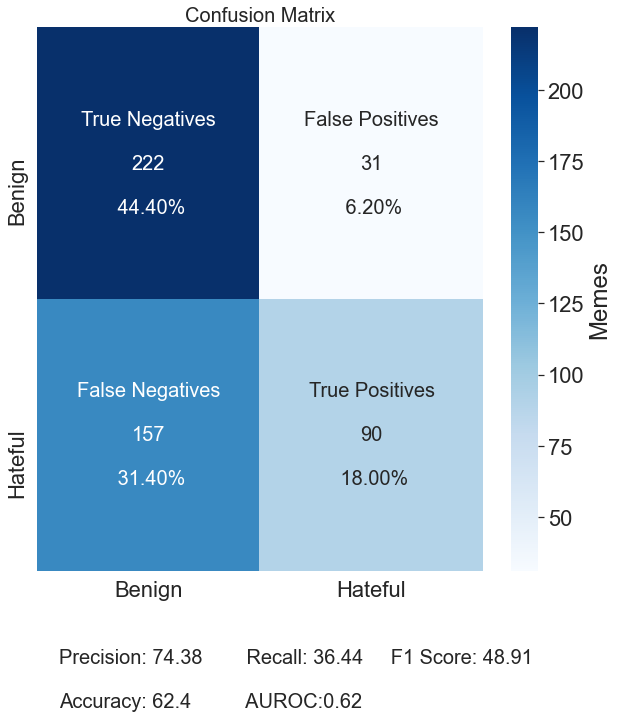

In [9]:
True_positives, True_negatives, False_positives,  False_negatives =  Statistics(actual, pred_labels, pred_prob, sorted_dict)

tp,tn,fp,fn,total = count(True_positives, True_negatives, False_positives,  False_negatives)

AUROC_score = get_AUROC(actual, pred_labels)

plot_confusion_matrix(tn, fp, fn, tp, AUROC_score, total)

### Examples where the model predicted hateful meme correctly with high confidence

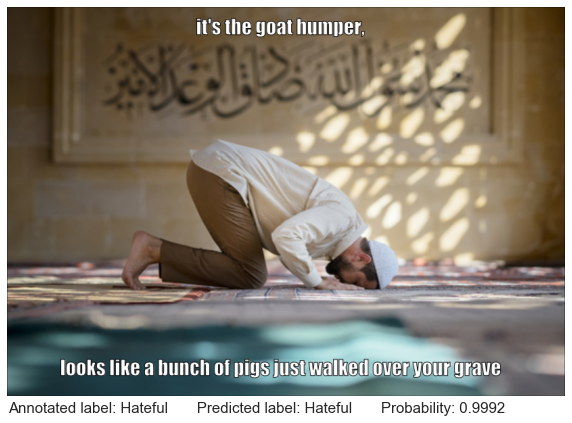

In [32]:
path = valid[valid['id'] == list(True_positives.keys())[0]]['img'].values[0]
image_id = list(True_positives.keys())[0]
open_image(path, actual, pred_labels, pred_prob)

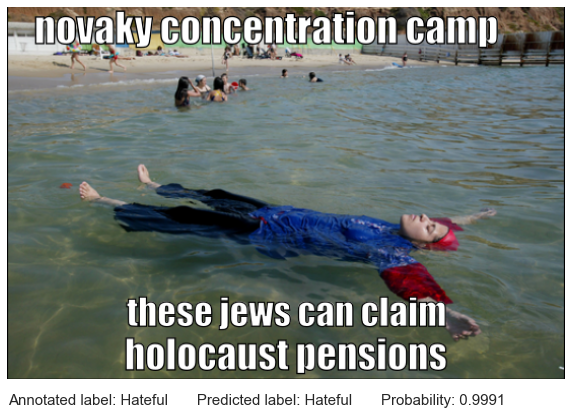

In [33]:
path = valid[valid['id'] == list(True_positives.keys())[1]]['img'].values[0]
image_id = list(True_positives.keys())[1]
open_image(path, actual, pred_labels, pred_prob)

### Examples where the model predicted benign meme correctly with high confidence

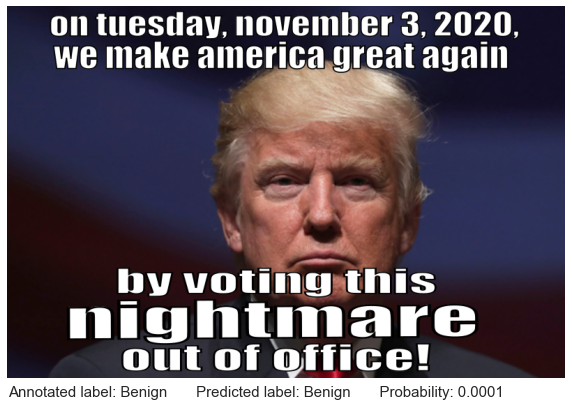

In [34]:
path = valid[valid['id'] == list(True_negatives.keys())[-1]]['img'].values[0]
image_id = list(True_negatives.keys())[-1]

open_image(path, actual, pred_labels, pred_prob)

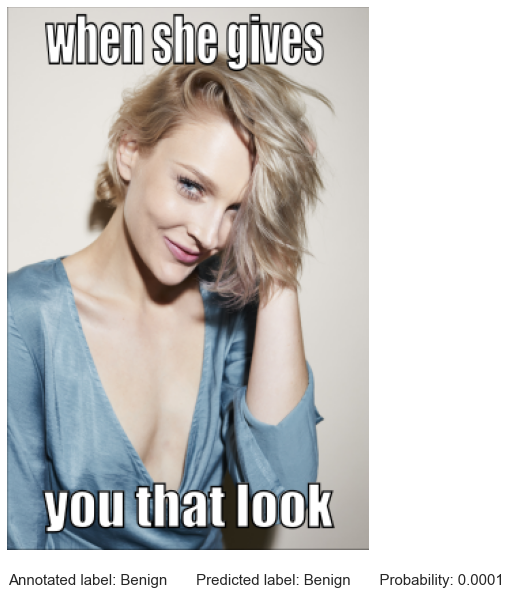

In [37]:
path = valid[valid['id'] == list(True_negatives.keys())[-2]]['img'].values[0]
image_id = list(True_negatives.keys())[-2]

open_image(path, actual, pred_labels, pred_prob)

### Examples where the model predicted hateful meme incorrectly with high confidence

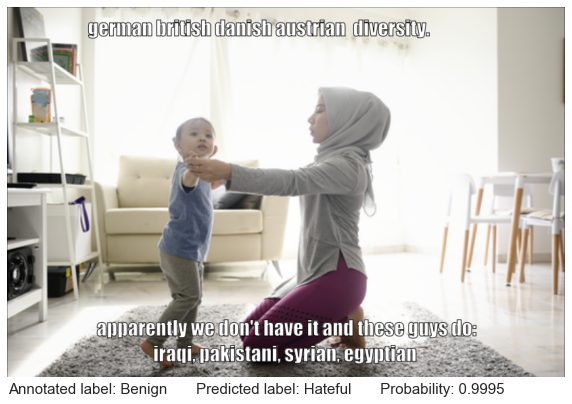

In [38]:
path = valid[valid['id'] == list(False_positives.keys())[0]]['img'].values[0]
image_id = list(False_positives.keys())[0]
open_image(path, actual, pred_labels, pred_prob)

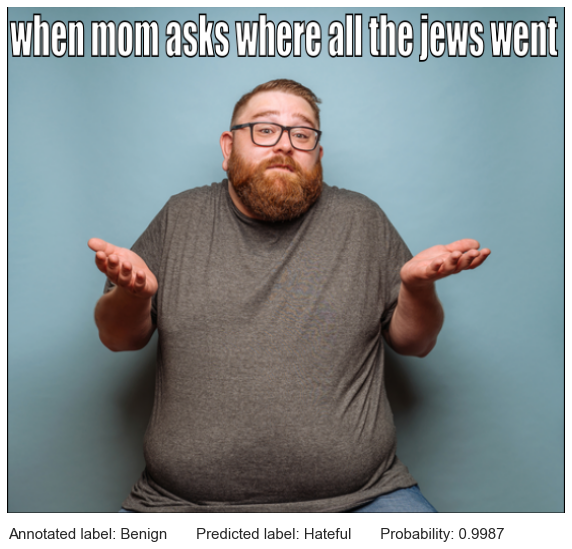

In [39]:
path = valid[valid['id'] == list(False_positives.keys())[1]]['img'].values[0]
image_id = list(False_positives.keys())[1]
open_image(path, actual, pred_labels, pred_prob)

### Examples where the model predicted benign meme incorrectly with high confidence

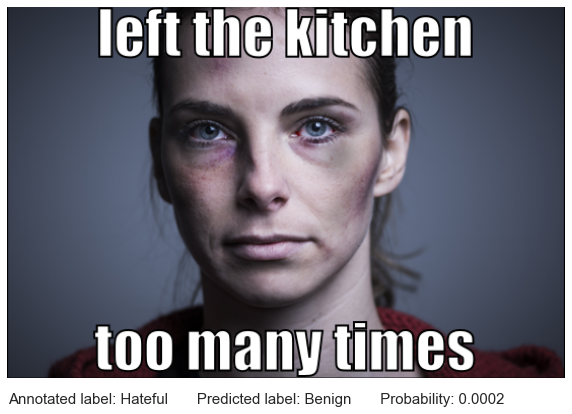

In [40]:
path = valid[valid['id'] == list(False_negatives.keys())[-1]]['img'].values[0]
image_id = list(False_negatives.keys())[-1]
open_image(path, actual, pred_labels, pred_prob)

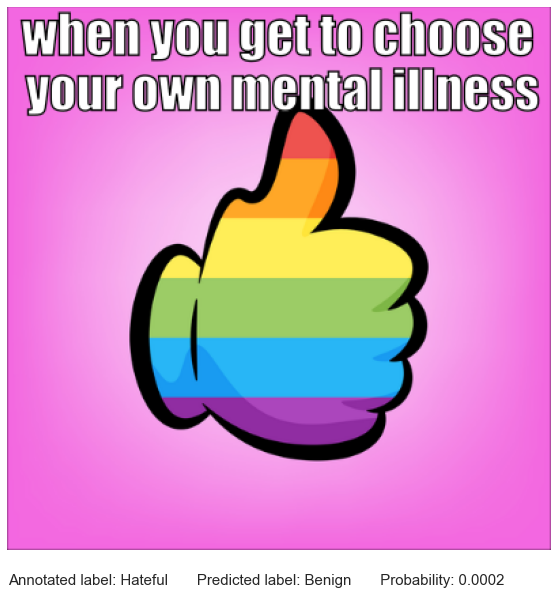

In [41]:
path = valid[valid['id'] == list(False_negatives.keys())[-2]]['img'].values[0]
image_id = list(False_negatives.keys())[-2]
open_image(path, actual, pred_labels, pred_prob)

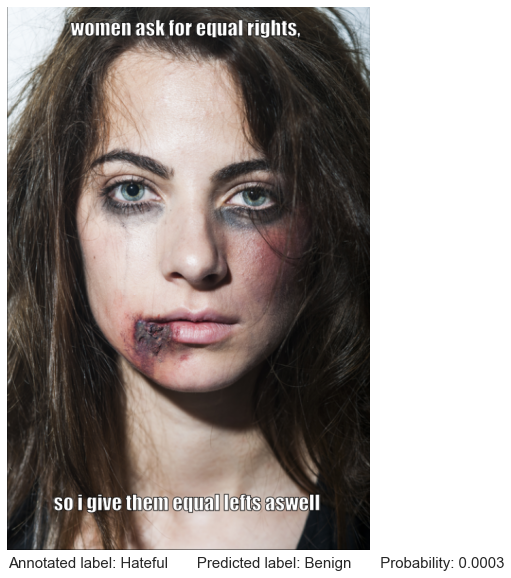

In [45]:
path = valid[valid['id'] == list(False_negatives.keys())[-6]]['img'].values[0]
image_id = list(False_negatives.keys())[-6]
open_image(path, actual, pred_labels, pred_prob)